In [30]:
import pandas as pd
import numpy as np
import itertools
import math
import sys
sys.path.insert(0, '../..')

import matplotlib.pyplot as plt

from g4l.data import Sample
import g4l.display
from g4l.tree import ContextTree

#cache_dir = '../example1/cache'

In [31]:
# Create a sample object instance
X = Sample('../example1/folha.txt', [0, 1, 2, 3, 4])
t = ContextTree(X, max_depth=4)

In [32]:
df = t.df.copy()
# initialize
df.final = 1
df['children_contrib'] = df.transition_sum_log_probs
df.loc[df.lps==0, 'children_contrib'] = -math.inf

In [33]:
# mark all nodes in the last level as leaves
df['type'] = 'N' # simple node

max_node_length = df.l.max() # 4
df.loc[df.l==max_node_length, 'type'] = 'L' # (mark as leaf)

In [34]:
df_results = pd.DataFrame(columns=['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx'])
df_results.node_idx = df_results.node_idx.astype(object)

In [35]:
# iteration block

iteration_num = 0
while df.final.sum()>0:
    # fetch all nodes connected to leaf nodes and mark them as parent of leaves (LP)
    parent_node_idx = df.loc[(df.final==1) & (df.type=='L')].parent_idx.unique()
    df.loc[df.node_idx.isin(parent_node_idx), 'type'] = 'LP' # leaf parent

    # for all LP nodes, mark as candidate those ones that connects only with leaf nodes
    lp_nodes = df.loc[(df.type=='LP') & (df.final==1)]
    for idx, lp_node in lp_nodes.iterrows():
        child_nodes = df[df.parent_idx==lp_node.node_idx]

        num_child_nodes = len(child_nodes)
        active_child_nodes = (child_nodes.final==1).astype(int).sum()
        leaf_nodes = (child_nodes.type=='L').astype(int).sum()
        # when all child nodes are leaves and active
        if num_child_nodes == active_child_nodes == leaf_nodes:
            df.loc[df.node_idx==lp_node.node_idx, 'type'] = 'LPC' # mark these nodes as candidates (LPC)

    lpc = df[df.type=='LPC']
    if len(lpc)==0:
        break
    
    # for all the candidate nodes (LPC), calculate the less contributive
    less_contributive_lp_idx = np.array(lpc.sort_values(['children_contrib']).node_idx)[0]    
    
    # Eliminate leaves
    df.loc[df.parent_idx==less_contributive_lp_idx, 'final'] = 0

    # The less contributive LPC becomes a leaf
    df.loc[df.node_idx==less_contributive_lp_idx, 'type'] = 'L'
    iteration_num += 1

    active_nodes = df[df.final==1]
    # ['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx']
    df_results.loc[len(df_results)] = [iteration_num, len(active_nodes), active_nodes[active_nodes.type=='L'].lps.sum(), np.array(active_nodes.node_idx)]

In [36]:
x = df_results.sort_values(['log_likelihood_sum'], ascending=False).node_idx[:1]
nodes_idx = x.to_numpy()[0]
new_df = t.df.copy()
new_df = new_df[new_df.node_idx.isin(nodes_idx)]
new_df.final = 1
new_t = ContextTree(X, max_depth=4, source_data_frame=new_df)

In [37]:
g4l.display.draw_tree(t.to_str(), size='400')
# the last iteration has length=1 

In [38]:
g4l.display.draw_tree(new_t.to_str(), size='40')
# the last iteration has length=1 

In [39]:
new_t.df

,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final
0,1,0,0,None,0,44111,-62840.152905,"[0.23846659563374215, 0.29559520301058695, 0.3...",-9.367255,0,1
1,1,1,1,None,1,21830,-18794.382713,"[0.6933577645442052, 0.0, 0.20998625744388455,...",-8.296834,0,1
2,1,2,2,None,2,21830,-14715.435172,"[0.5972972972972973, 0.4027027027027027, 0.0, ...",-1.424897,0,1
3,1,3,3,None,3,7909,-6671.568838,"[0.6849159185737768, 0.0, 0.2073587052724744, ...",-9.670055,0,1
4,1,4,4,None,4,2070,-1325.580428,"[0.0, 0.0, 0.6608695652173913, 0.3381642512077...",-1.498422,0,1
...,...,...,...,...,...,...,...,...,...,...,...
745,4,745,590,148,0334,2,-1.386294,"[0.0, 0.0, 0.5, 0.5, 0.0]",-1.386294,0,1
746,4,746,591,148,1334,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,1
747,4,747,592,148,2334,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,1
748,4,748,593,148,3334,1,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0]",0.000000,0,1


In [40]:
results = df_results.sort_values(['num_nodes'], ascending=True)

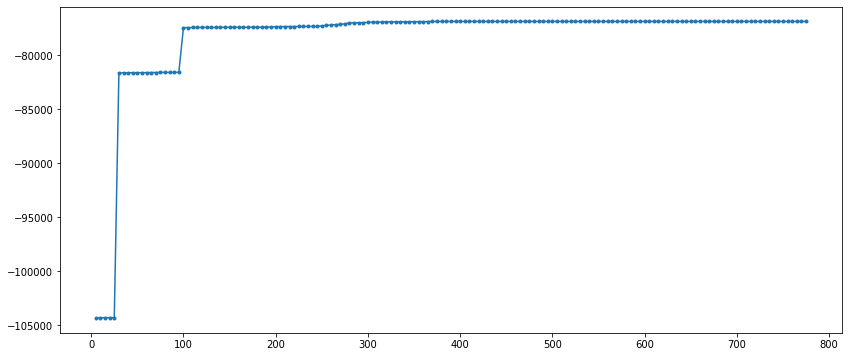

,iter_num,num_nodes,log_likelihood_sum,node_idx
154,155,5,-104347.120057,"[0, 1, 2, 3, 4]"
153,154,10,-104326.960211,"[0, 1, 2, 3, 4, 15, 16, 17, 18, 19]"
152,153,15,-104319.585953,"[0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 95, 96, 97..."
151,152,20,-104317.242574,"[0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 95, 96, 97..."
150,151,25,-104317.067132,"[0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 95, 96, 97..."
...,...,...,...,...
4,5,755,-76844.704857,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,4,760,-76844.704857,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,3,765,-76844.704857,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,770,-76844.704857,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [43]:
plt.figure(figsize=(14, 6))
plt.plot(results.num_nodes, results.log_likelihood_sum, marker='.')
#plt.plot(results.num_nodes, results.log_likelihood_sum)
plt.show()
results

In [12]:
t.log_likelihood()


-339854.51291223057

780

In [29]:
df.lps

0     -62840.152905
1     -18794.382713
2     -14715.435172
3      -6671.568838
4      -1325.580428
           ...     
775        0.000000
776        0.000000
777        0.000000
778        0.000000
779        0.000000
Name: lps, Length: 780, dtype: float64

In [21]:
t.log_likelihood()

-339854.51291223057